# Transforming images into csv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import csv
import cv2

In [2]:
def implt(img, cmp=None, t=''):
    """ Show image using plt """
    plt.imshow(img, cmap=cmp)
    plt.title(t)
    plt.show()


def correspondingShuffle(a, b):
    """ Shuffle the numpy array so that a[i] correspond to b[i]"""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

    
def resize(img, size = 56):
    """ Resize bigger side of the image to given size """
    if (img.shape[0] > img.shape[1]):
        rat = size / img.shape[0]
        return cv2.resize(img, (int(rat * img.shape[1]), size))
    else:
        rat = size / img.shape[1]
        return cv2.resize(img, (size, int(rat * img.shape[0])))
    return img


def autocrop(image, threshold=80):
    """ Crops edges below or equal to threshold """
    rows = np.where(np.max(image, 0) > threshold)[0]
    cols = np.where(np.max(image, 1) > threshold)[0]
    image = image[cols[0]:cols[-1] + 1, rows[0]:rows[-1] + 1]
    return image


def imgPreprocess(image):
    """ Preprocess an image - crop """
    image = autocrop(image)
    resized = resize(image)
    
    result = np.zeros((64, 64), np.uint8)
    offset = [0, 0]
    # Calculate offset for smaller size
    if image.shape[0] > image.shape[1]:
        offset = [int((result.shape[1] - resized.shape[1])/2), 4]
    else:
        offset = [4, int((result.shape[0] - resized.shape[0])/2)]
    # Replace zeros by image 
    result[offset[1]:offset[1] + resized.shape[0],
           offset[0]:offset[0] + resized.shape[1]] = resized
    return result

In [3]:
def createDataCSV(dataloc, lang):
    """ Create images and labels CSV file for given data """
    print("Creating " + lang + " dataset")
    # Get subfolders with images
    dirlist = glob.glob(dataloc + lang + "/*/")
    dirlist.sort()
    chars = [name[17] for name in dirlist]

    images = np.zeros((1, 4096))
    labels = []

    # For every label load images and create labels
    # cv2.imread(img, 0) - for loading images in grayscale
    # Images are scaled to 64x64
    for i in range(len(chars)):
        imglist = glob.glob(dirlist[i] + '*.jpg')
        imgs = np.array([imgPreprocess(cv2.imread(img, 0)) for img in imglist])
        images = np.concatenate([images, imgs.reshape(len(imgs), 4096)])
        labels.extend([i] * len(imgs))

    images = images[1:]
    labels = np.array(labels)

    assert len(labels) == len(images)
    print("Images: %d" % len(labels))
    print("For %d different labels" % len(chars))

    images, labels = correspondingShuffle(images, labels)    

    with open(dataloc + lang + '-data.csv', 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for row in images:
            writer.writerow(row)

    with open(dataloc + lang + '-labels.csv', 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(labels)

    implt(images[-1].reshape(64,64), 'gray', 'Example')
    print("CSV data files saved.")

Creating cz dataset
Images: 1813
For 83 different labels


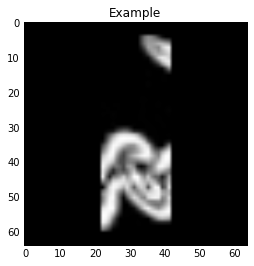

CSV data files saved.
Creating en dataset
Images: 1807
For 53 different labels


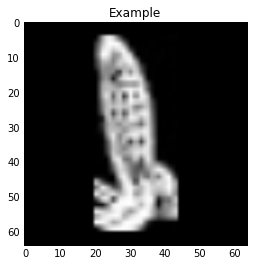

CSV data files saved.


In [4]:
LANG_CZ = 'cz'
LANG_EN = 'en'
DATA_LOC = 'data/charclas/'

createDataCSV(DATA_LOC, LANG_CZ)
createDataCSV(DATA_LOC, LANG_EN)